In [1]:
import logging
import pymc3 as pm
import numpy as np
print(pm.__version__)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


3.11.4


In [2]:
from functools import partial
from scipy.stats import norm

def poly_basis(x,power):
    return x**power

def gauss_basis(x,mu,sigma):
    return norm(loc=mu, scale=sigma).pdf(x).astype(np.float32)

def _expand(x,bf,bf_args):
    return np.stack([bf(x,bf_arg) for bf_arg in bf_args], axis=1)

def expand_poly(x,deg=3):
    return _expand(x, bf =poly_basis, bf_args=range(1, deg+1))

def expand_gauss(x,mus=np.linspace(0,1,9), sigma=0.3):
    return _expand(x,bf=partial(gauss_basis, sigma=sigma), bf_args=mus)

#select between polynomial and gaussian expansion
#( by switching the comment on the following 2 lines)
expand = expand_poly
#expand = expnad_gauss

In [3]:
expand_poly(np.array([0.5,1.5]), deg=3)

array([[0.5  , 0.25 , 0.125],
       [1.5  , 2.25 , 3.375]])

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

from bayesian_linear_regression_util import (
    plot_data, 
    plot_truth
)

def f(x, noise=0):
    """Sinusoidal function with optional Gaussian noise."""
    return 0.5 + np.sin(2 * np.pi * x) + np.random.normal(scale=noise, size=x.shape)

# Number of samples
N = 10

# Constant noise 
noise = 0.3

# Noisy samples 
x = np.linspace(0, 1, N, dtype=np.float32)
t = f(x, noise=noise)

# Noise-free ground truth 
x_test = np.linspace(0, 1, 100).astype(np.float32)
y_true = f(x_test)

plot_data(x, t)
plot_truth(x_test, y_true)

ModuleNotFoundError: No module named 'bayesian_linear_regression_util'

In [9]:
from theano import shared
N=20
noise=0.5

def f(x, noise=0):
    """Sinusoidal function with optional Gaussian noise."""
    return 0.5 + np.sin(2 * np.pi * x) + np.random.normal(scale=noise, size=x.shape)

t= f(x,noise=noise)
x = np.linspace(0,1,N, dtype=np.float32)
Phi = expand(x)
Phi_shared = shared(Phi)

with pm.Model() as model:
    w_0 = pm.Normal('w_0', mu=0, sigma=10)
    w_r = pm.Normal('w_r', mu=0, sigma=10, shape=Phi.shape[1])

    mu = w_0 + w_r.dot(Phi_shared.T)
    
    t_obs = pm.Normal('t_obs', mu=mu, sigma=noise, observed=t)

In [10]:
with model:
    trace = pm.sample()

<ipython-input-10-3a6b5294a20f>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Mfund\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Mfund\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Mfund\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_r, w_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 136 seconds.
The number of effective samples is smaller than 25% for some parameters.


<ipython-input-11-b3e5122105cb>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, compact=False);
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Mfund\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


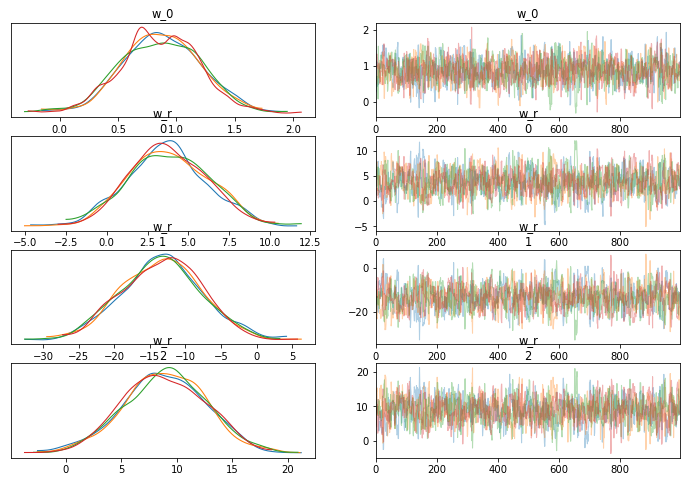

In [11]:
pm.traceplot(trace, compact=False);

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Mfund\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Mfund\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'w_r\n0'}>,
       <AxesSubplot:title={'center':'w_r\n1'}>,
       <AxesSubplot:title={'center':'w_r\n2'}>], dtype=object)

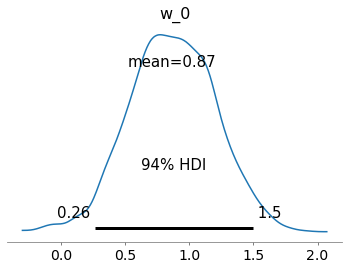

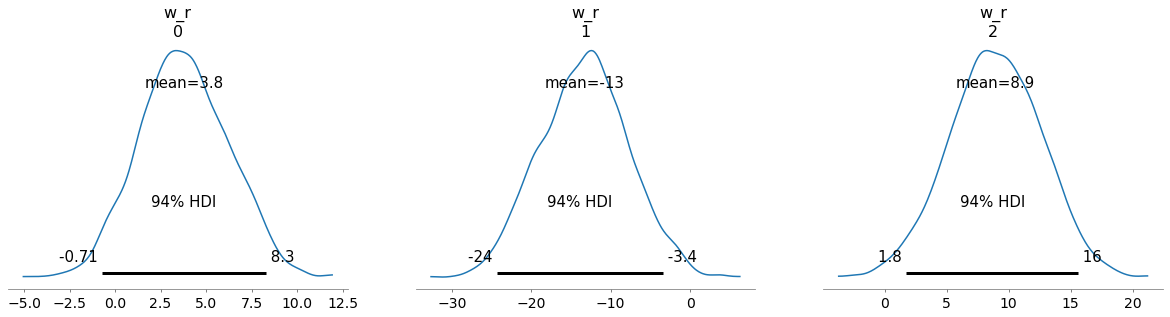

In [12]:
pm.plot_posterior(trace, var_names="w_0")
pm.plot_posterior(trace, var_names="w_r")

In [14]:
x_test = np.linspace(0, 1, 100).astype(np.float32)
y_true = f(x_test)

In [15]:
Phi_shared.set_value(expand(x_test))
predictive_samples = pm.sample_posterior_predictive(trace, model=model, samples=5000)['t_obs']

NameError: name 'plot_data' is not defined

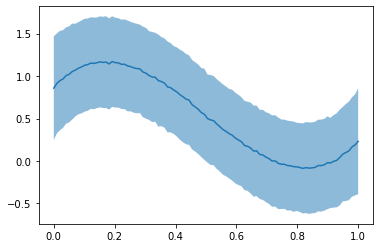

In [16]:
m = np.mean(predictive_samples, axis=0)
s = np.std(predictive_samples, axis=0)

plt.fill_between(x_test, m + s, m - s, alpha = 0.5, label='Predictive std. dev.')
plt.plot(x_test, m, label='Predictive mean');

plot_data(x, t)
plot_truth(x_test, y_true, label=None)

plt.legend();